In [ ]:
# importing libraries
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

import matplotlib.pyplot as plt


## Part 1: Data Cleaning


In [2]:
# load dataset
df = pd.read_csv('property_data.csv')
df.head()

,BedRooms,Bath rooms,Size_sqft,location,year built,Garage Available,Furnishing,House Condition,Has_Pool,Lot Size,Price($)
0,3.0,1.0,1149,Rural,2004,NaN,Unfurnished,new,0.0,0.15,244043
1,NaN,2.0,1169,Rural,1989,1.0,NaN,Old,0.0,0.23,211250
2,4.0,3.0,1409,Suburban,1993,1.0,Unfurnished,gd,0.0,0.19,257239
3,3.0,3.0,1647,Suburban,2021,0.0,NaN,new,0.0,0.27,310316
4,2.0,3.0,1865,Urban,2009,0.0,furnised,old,1.0,0.39,334791


In [3]:
# shape
df.shape

(1000, 11)

In [4]:
# inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0    BedRooms         954 non-null    float64
 1   Bath rooms        941 non-null    float64
 2   Size_sqft         1000 non-null   int64  
 3   location          1000 non-null   object 
 4   year built        1000 non-null   int64  
 5   Garage Available  896 non-null    float64
 6   Furnishing        843 non-null    object 
 7   House Condition   1000 non-null   object 
 8   Has_Pool          945 non-null    float64
 9   Lot Size          1000 non-null   float64
 10  Price($)          1000 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 86.1+ KB


In [5]:
df.describe()

,BedRooms,Bath rooms,Size_sqft,year built,Garage Available,Has_Pool,Lot Size,Price($)
count,954.000000,941.000000,1000.000000,1000.00000,896.000000,945.000000,1000.00000,1000.000000
mean,2.912998,1.989373,1505.170000,2001.59500,0.533482,0.280423,0.25540,277133.174000
std,1.161547,0.836592,391.257815,12.42511,0.499156,0.449444,0.13628,59963.752729
min,1.000000,1.000000,292.000000,1980.00000,0.000000,0.000000,0.00000,87752.000000
25%,2.000000,1.000000,1241.750000,1991.00000,0.000000,0.000000,0.15000,236922.250000
50%,3.000000,2.000000,1500.000000,2002.00000,1.000000,0.000000,0.25000,277263.500000
75%,4.000000,3.000000,1769.000000,2012.00000,1.000000,1.000000,0.35000,317508.250000
max,5.000000,4.000000,2777.000000,2023.00000,1.000000,1.000000,0.76000,481326.000000


- Dataset covers 1000 houses, but some features have missing values (notably bedrooms, bathrooms, garage, and pool).
- Typical house: ~3 bedrooms, ~2 bathrooms, ~1505 sq ft, built around 2001.
- ~53% have a garage, ~28% have a pool, average lot size ~0.26 acres.
- Prices mostly between $236K–$318K, with extremes from ~$88K to ~$481K.
- Outliers include very small homes (292 sq ft) and zero lot sizes, which may require cleaning.

In [6]:
# clean column names
df.columns = (df.columns.str.strip().str.lower().str.replace(" ","_"))
df.rename(columns={"price($)": "price_usd"}, inplace=True)
df.head()

,bedrooms,bath_rooms,size_sqft,location,year_built,garage_available,furnishing,house_condition,has_pool,lot_size,price_usd
0,3.0,1.0,1149,Rural,2004,NaN,Unfurnished,new,0.0,0.15,244043
1,NaN,2.0,1169,Rural,1989,1.0,NaN,Old,0.0,0.23,211250
2,4.0,3.0,1409,Suburban,1993,1.0,Unfurnished,gd,0.0,0.19,257239
3,3.0,3.0,1647,Suburban,2021,0.0,NaN,new,0.0,0.27,310316
4,2.0,3.0,1865,Urban,2009,0.0,furnised,old,1.0,0.39,334791


In [7]:
# check missing values
df.isna().sum()

bedrooms             46
bath_rooms           59
size_sqft             0
location              0
year_built            0
garage_available    104
furnishing          157
house_condition       0
has_pool             55
lot_size              0
price_usd             0
dtype: int64

In [8]:
# fill numerical columns
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['bath_rooms'] = df['bath_rooms'].fillna(df['bath_rooms'].median())

In [9]:
# fill categorical columns with mode
for col in ["garage_available", "furnishing", "has_pool"]:
    df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
df.isna().sum()

bedrooms            0
bath_rooms          0
size_sqft           0
location            0
year_built          0
garage_available    0
furnishing          0
house_condition     0
has_pool            0
lot_size            0
price_usd           0
dtype: int64

In [11]:
df

,bedrooms,bath_rooms,size_sqft,location,year_built,garage_available,furnishing,house_condition,has_pool,lot_size,price_usd
0,3.0,1.0,1149,Rural,2004,1.0,Unfurnished,new,0.0,0.15,244043
1,3.0,2.0,1169,Rural,1989,1.0,Semi-Furnished,Old,0.0,0.23,211250
2,4.0,3.0,1409,Suburban,1993,1.0,Unfurnished,gd,0.0,0.19,257239
3,3.0,3.0,1647,Suburban,2021,0.0,Semi-Furnished,new,0.0,0.27,310316
4,2.0,3.0,1865,Urban,2009,0.0,furnised,old,1.0,0.39,334791
...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,2.0,1274,urbn,2002,1.0,Furnished,Old,0.0,0.02,237767
996,5.0,2.0,1909,sub-urban,1997,0.0,Semi-Furnished,New,1.0,0.16,363716
997,2.0,1.0,2335,Urban,1993,1.0,furnised,Old,1.0,0.13,403535
998,3.0,1.0,866,urbn,1994,0.0,Semi furnished,Old,0.0,0.44,169833


In [12]:
# standardizing categorical columns
# location
df["location"] = df["location"].str.strip().str.lower()
df["location"] = df["location"].replace({
    "urbn": "urban",
    "urban": "urban",
    "suburban": "suburban",
    "sub-urban": "suburban",
    "rural": "rural",
    "ruraal": "rural"
})

# furnishing
df["furnishing"] = df["furnishing"].str.strip().str.lower()
df["furnishing"] = df["furnishing"].replace({
    "furnished": "furnished",
    "furnised": "furnished",
    "unfurnished": "unfurnished",
    "semi-furnished": "semi-furnished",
    "semi furnished": "semi-furnished"
})

In [13]:
# house condition
df["house_condition"] = df["house_condition"].str.strip().str.lower()
df["house_condition"] = df["house_condition"].replace({
    "new": "new",
    "old": "old",
    "gd": "good"
})

In [14]:
df.tail(30)

,bedrooms,bath_rooms,size_sqft,location,year_built,garage_available,furnishing,house_condition,has_pool,lot_size,price_usd
970,4.0,1.0,1647,suburban,1980,1.0,furnished,old,0.0,0.01,284336
971,5.0,3.0,1375,rural,2006,1.0,semi-furnished,new,0.0,0.20,267331
972,4.0,1.0,1869,suburban,1995,1.0,furnished,good,1.0,0.33,336703
973,2.0,2.0,1693,urban,2017,1.0,furnished,new,0.0,0.43,313903
974,1.0,1.0,1668,urban,1986,1.0,furnished,good,0.0,0.10,300934
975,2.0,4.0,1743,suburban,2023,0.0,semi-furnished,good,0.0,0.36,312728
976,3.0,1.0,2323,rural,2002,0.0,semi-furnished,new,0.0,0.38,403156
977,1.0,2.0,1048,rural,2020,0.0,furnished,old,1.0,0.17,202141
978,3.0,3.0,1689,rural,1990,0.0,furnished,good,0.0,0.26,307232
979,3.0,3.0,1129,suburban,2021,1.0,furnished,new,1.0,0.21,244613


In [15]:
df.dtypes

bedrooms            float64
bath_rooms          float64
size_sqft             int64
location             object
year_built            int64
garage_available    float64
furnishing           object
house_condition      object
has_pool            float64
lot_size            float64
price_usd             int64
dtype: object

In [16]:
# fix datatypes
# Convert bedroom & bathroom counts to int
df["bedrooms"] = df["bedrooms"].astype(int)
df["bath_rooms"] = df["bath_rooms"].astype(int)

# Convert garage & pool availability to bool
df["garage_available"] = df["garage_available"].astype(bool)
df["has_pool"] = df["has_pool"].astype(bool)

### Quick Summary of cleaning done:
1. Standardized column names (lowercase + underscores). (e.g. price($) to price_usd)

2. Handled missing values:

    - Filled bedrooms and bath_rooms with median.

    - Filled categorical columns (garage_available, furnishing, has_pool) with mode.

3. Standardized categorical values:

    - location: urban, suburban, rural.

    - furnishing: furnished, semi-furnished, unfurnished.

    - house_condition: new, good, old.

4. Corrected data types:

    - Integers for counts and year, booleans for binary flags.

## Part 2: Feature Engineering and Modeling 

In [17]:
#get house age
current_year = datetime.now().year
df['house_age'] = current_year - df['year_built']
df.head()

,bedrooms,bath_rooms,size_sqft,location,year_built,garage_available,furnishing,house_condition,has_pool,lot_size,price_usd,house_age
0,3,1,1149,rural,2004,True,unfurnished,new,False,0.15,244043,21
1,3,2,1169,rural,1989,True,semi-furnished,old,False,0.23,211250,36
2,4,3,1409,suburban,1993,True,unfurnished,good,False,0.19,257239,32
3,3,3,1647,suburban,2021,False,semi-furnished,new,False,0.27,310316,4
4,2,3,1865,urban,2009,False,furnished,old,True,0.39,334791,16


In [18]:
# prepare features
target = "price_usd"
X = df.drop(columns=[target])
y = df[target]

In [19]:
# define feature groups
numeric_features = ["bedrooms", "bath_rooms", "size_sqft", "lot_size", "house_age", "garage_available", "has_pool"]
categorical = ["location", "furnishing", "house_condition"]

In [20]:
# train/test split(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# preprocessing
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numeric_features),
    ("cat", cat_transformer, categorical)
], remainder="drop")

In [22]:
# define model (random forest)
house_price_predictor = RandomForestRegressor(random_state=42, n_jobs=-1)

# build pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", house_price_predictor)
])

In [23]:
missing_cols = [col for col in numeric_features + categorical if col not in X_train.columns]
print("Missing from X_train:", missing_cols)


Missing from X_train: []


In [24]:
# Baseline CV evaluation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
cv_rmse = -cv_scores.mean()
print(f"Baseline CV RMSE: {cv_rmse:.2f}")


Baseline CV RMSE: 12432.07


In [25]:
# hyperparameter tuning(small grid)
param_grid = {
    "regressor__n_estimators": [100, 200],  # number of trees
    "regressor__max_depth": [10, 20, None], # tree depth
    "regressor__min_samples_leaf": [1, 3, 5] # minimum samples per leaf
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}


In [26]:
# evaluation on test set
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.3f}")

Test MAE: 8392.35
Test RMSE: 10728.18
Test R^2: 0.969


## Visualisations

In [27]:
# Feature importance
# We need feature names produced by ColumnTransformer + OneHotEncoder
# get numeric feature names
num_names = numeric_features

# get categorical names from the onehot encoder inside the pipeline
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = list(ohe.get_feature_names_out(categorical))

feature_names = num_names + cat_names

importances = best_model.named_steps["regressor"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp)

size_sqft                    0.971610
house_condition_new          0.007902
house_age                    0.005438
lot_size                     0.003497
house_condition_old          0.002698
bedrooms                     0.001818
has_pool                     0.001466
garage_available             0.001169
bath_rooms                   0.001024
furnishing_semi-furnished    0.000591
location_suburban            0.000564
location_rural               0.000549
location_urban               0.000509
furnishing_furnished         0.000497
house_condition_good         0.000461
furnishing_unfurnished       0.000205
dtype: float64


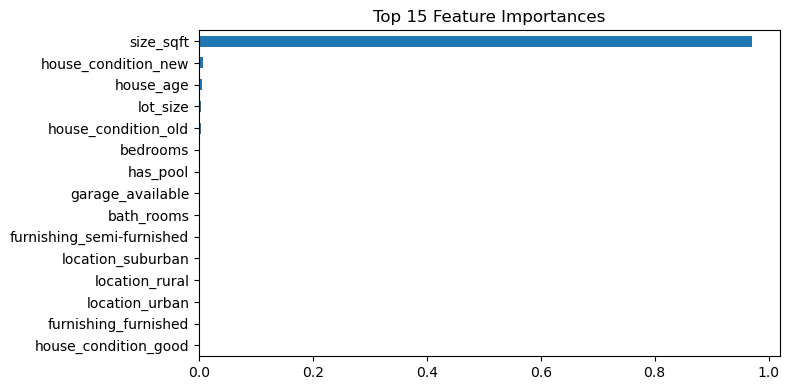

In [28]:
# Top feature importances
plt.figure(figsize=(8,4))
feat_imp.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

`size_sqft` = 97% importance meaning "The bigger the house, the higher the predicted price" according to the model.
The next most important feature (`house_condition_new`) is <1%, all others are in the fractions of a percent.

This means:

- The dataset is very strongly correlated between size and price.

- The other variables don’t add much unique information given `size_sqft`.

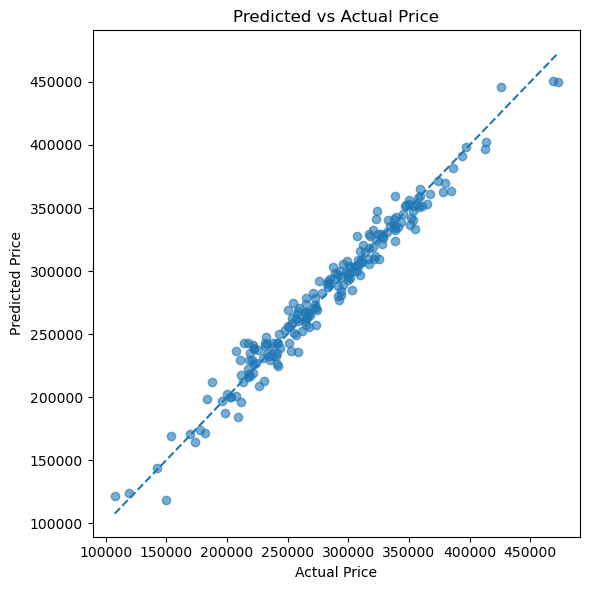

In [29]:
# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price")
plt.tight_layout()
plt.show()

Since most points are around the line, the model’s predictions are very close to the actual prices for most houses.

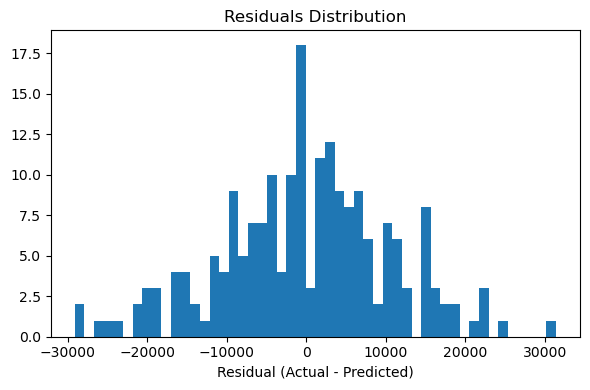

In [30]:
# Residuals histogram
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residuals Distribution")
plt.tight_layout()
plt.show()

The residuals are mostly centered around 0, indicating that the model is not systematically overpredicting or underpredicting. The roughly symmetric spread suggests a reasonably balanced error distribution, although some outliers exist on both sides, which could be due to unusual properties in the dataset.

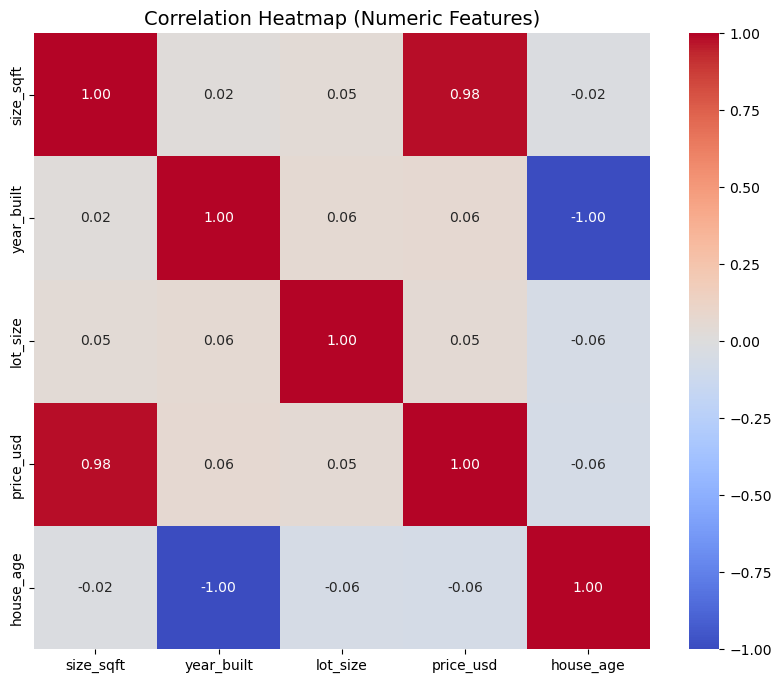

In [32]:
import seaborn as sns

numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=14)
plt.show()

### Sample input prediction 


In [33]:
sample_data = pd.DataFrame([
    {
        "bedrooms": 3,
        "bath_rooms": 2,
        "size_sqft": 1500,
        "lot_size": 0.25,
        "house_age": 10,
        "garage_available": True,
        "has_pool": False,
        "location": "Suburban",
        "furnishing": "Semi-Furnished",
        "house_condition": "Good"
    },
    {
        "bedrooms": 5,
        "bath_rooms": 4,
        "size_sqft": 3000,
        "lot_size": 0.5,
        "house_age": 2,
        "garage_available": True,
        "has_pool": True,
        "location": "Urban",
        "furnishing": "Furnished",
        "house_condition": "New"
    },
    {
        "bedrooms": 2,
        "bath_rooms": 1,
        "size_sqft": 900,
        "lot_size": 0.15,
        "house_age": 25,
        "garage_available": False,
        "has_pool": False,
        "location": "Rural",
        "furnishing": "Unfurnished",
        "house_condition": "Old"
    }
])

# Predict prices
predicted_prices = best_model.predict(sample_data)

# Output results
for i, price in enumerate(predicted_prices):
    print(f"Sample {i+1} predicted price: ${price:,.2f}")

Sample 1 predicted price: $273,365.05
Sample 2 predicted price: $450,955.15
Sample 3 predicted price: $173,779.24


### Interpretation:
- Sample 1: A moderately sized family home in a suburban area with decent condition and amenities, leading to a mid-range price.
- Sample 2: A large, new property with premium features (pool, garage, urban location, high furnishing quality) commanding a high price.
- Sample 3: A smaller, older property in a rural location with fewer amenities, resulting in a lower price point.

In [34]:
# save cleaned dataset
df.to_csv('cleaned_property_data.csv', index=False)
print("saved cleaned dataset to cleaned_property_data.csv")

saved cleaned dataset to cleaned_property_data.csv
